# 目的
bypitflyerのテスト。   
まずは基本的な動作を確認する。

In [17]:
import numpy as np
import pybitflyer as pbf
import os
import getpass
import pickle
import matplotlib.pyplot as plt
import glob
import time
%matplotlib inline

## API Keyの読み込み
APIキーの所在を見えにくくするために、 `getpass` と環境変数を用いる。

In [3]:
fldrname_for_key = getpass.getpass("folder for key:")
fpath = glob.glob(os.path.join(os.environ["USERPROFILE"], fldrname_for_key, "*"))[0]

with open(fpath, "r", encoding="utf-8") as ff:
    try:
        api_key = ff.readline().strip()
        api_secret = ff.readline().strip()
        print("ok")
    except:
        print("ng")

folder for key:········
ok


In [4]:
api = pbf.API(api_key=api_key, api_secret=api_secret)

## APIのテスト

### board
boardにはその時の板情報が含まれている。   
`volume_by_product` が対象としている銘柄の総取引量を表す。

```json
{
    "product_code": "BTC_JPY",
    "timestamp": "2018-06-13T16:22:35.97",
    "tick_id": 6199401,
    "best_bid": 711681,
    "best_ask": 711838,
    "best_bid_size": 1.001263,
    "best_ask_size": 0.078737,
    "total_bid_depth": 1304.18418795,
    "total_ask_depth": 2361.91584139,
    "ltp": 711680,
    "volume": 315987.58745009,
    "volume_by_product": 14402.44980525
}
```

In [18]:
wait_for = 1.0
for ii in range(10):
    st = time.time()
    result = api.board(product_code="FX_BTC_JPY")
    time.sleep(wait_for - (time.time() - st))

In [8]:
result = api.board(product_code="FX_BTC_JPY")

bids_price = None
bids_size = None
asks_price = None
asks_size = None
mid_price = -1
if result is not None:
    if "status" in result.keys():
        raise ValueError()
    asks, bids, mid_price = result["asks"], result["bids"], result["mid_price"]
    asks_price = np.array([_["price"] for _ in asks])
    asks_size = np.array([_["size"] for _ in asks])
    bids_price = np.array([_["price"] for _ in bids])
    bids_size = np.array([_["size"] for _ in bids])
    del asks, bids

In [9]:
(asks_price*asks_size).sum() - (bids_price*bids_size).sum() # >0: 買いが優勢？

3607481639.0485077

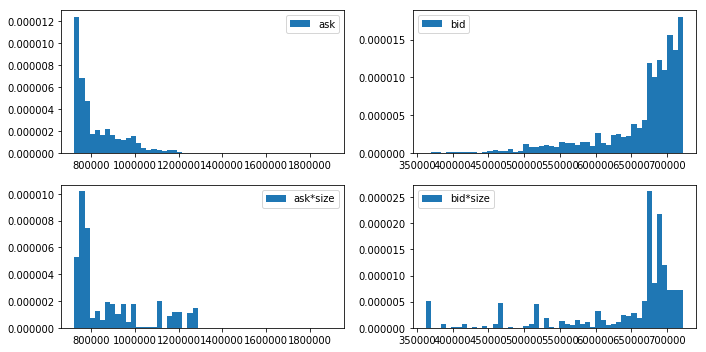

In [10]:
n_bins = 50
plt.figure(figsize=(10, 5))
plt.subplot(221)
# xbins = np.linspace(asks_price.min(), asks_price.max(), n_bins)
# histo, xbins = np.histogram(asks_price, bins=xbins, weights=asks_size)
y, x, _ = plt.hist(asks_price, bins=n_bins, density=True, label="ask")
plt.legend()

plt.subplot(222)
y, x, _ = plt.hist(bids_price, bins=n_bins, density=True, label="bid")
plt.legend()

plt.subplot(223)
y, x, _ = plt.hist(asks_price, bins=n_bins, density=True, weights=asks_size, label="ask*size")
plt.legend()

plt.subplot(224)
y, x, _ = plt.hist(bids_price, bins=n_bins, density=True, weights=bids_size, label="bid*size")
plt.legend()

plt.tight_layout()

### ticker
tickerにはその時の情報サイズなどの情報が入っている。

In [5]:
result = api.ticker(product_code="FX_BTC_JPY")
result


{'product_code': 'FX_BTC_JPY',
 'timestamp': '2018-06-23T12:10:51.05',
 'tick_id': 320817,
 'best_bid': 687797.0,
 'best_ask': 687856.0,
 'best_bid_size': 0.2246,
 'best_ask_size': 0.01,
 'total_bid_depth': 10796.14130991,
 'total_ask_depth': 12693.65337596,
 'ltp': 687797.0,
 'volume': 525729.22278546,
 'volume_by_product': 509480.10921254}

### execution
直近の約定履歴を取得する。   

```json
{
    "id": 255185675,
    "side": "BUY",
    "price": 712899,
    "size": 1.12999999,
    "exec_date": "2018-06-13T16:18:59.107",
    "buy_child_order_acceptance_id": "JRF20180613-161858-270387",
    "sell_child_order_acceptance_id": "JRF20180613-161844-756491"
}
```
